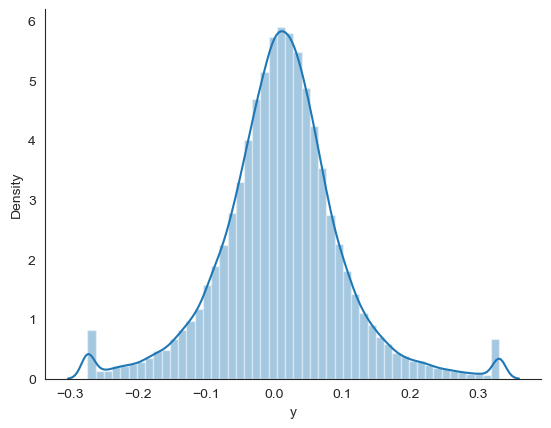

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import os, sys
from pathlib import Path

import numpy as np
from scipy.stats import spearmanr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, _tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error, make_scorer
import graphviz

import statsmodels.api as sm

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

sns.set_style('white')

results_path = Path('results', 'decision_trees')
if not results_path.exists():
    results_path.mkdir(parents=True)

with pd.HDFStore('data.h5') as store:
    data = store['us/equities/monthly']

# Generate two lags of monthly returns

X2 = data.loc[:, ['target', 'return_1m']]
X2.columns = ['y', 't-1']
X2['t-2'] = data.groupby(level='ticker').return_1m.shift()
X2 = X2.dropna()

y2 = X2.y
X2 = X2.drop('y', axis=1)

# Explore Data

# Note the small spike where we clipped the data.

sns.distplot(y2)
sns.despine();


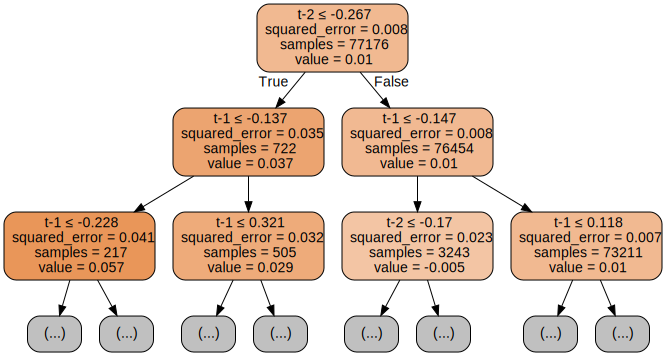

In [2]:
# Decision tree

reg_tree_t2 = DecisionTreeRegressor(criterion='squared_error',
                                    splitter='best',
                                    max_depth=6,
                                    min_samples_split=2,
                                    min_samples_leaf=50,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    random_state=42,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0)

# Train Decision Tree
reg_tree_t2.fit(X=X2, y=y2)


# Visualize Tree


out_file = results_path / 'reg_tree_t2.dot'
dot_data = export_graphviz(reg_tree_t2,
                          out_file=out_file.as_posix(),
                          feature_names=X2.columns,
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)


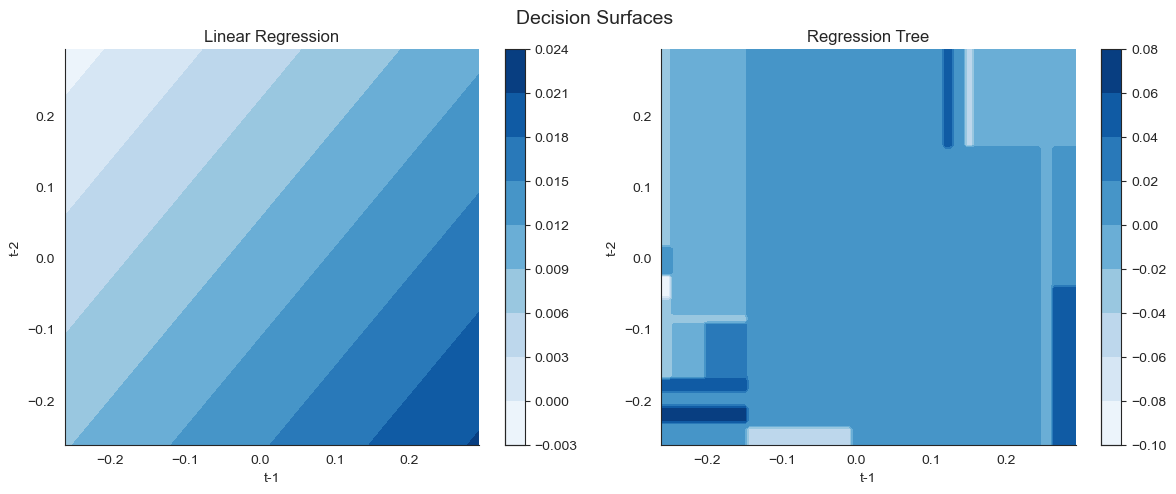

In [3]:
# sklearn Linear Regression

lin_reg = LinearRegression()

lin_reg.fit(X=X2,y=y2)

# Linear Regression vs Regression Tree Decision Surfaces

t1, t2 = np.meshgrid(np.linspace(X2['t-1'].quantile(.01), X2['t-1'].quantile(.99), 100),
                     np.linspace(X2['t-2'].quantile(.01), X2['t-2'].quantile(.99), 100))
X_data = np.c_[t1.ravel(), t2.ravel()]

fig, axes = plt.subplots(ncols=2, figsize=(12,5))

# Linear Regression
ret1 = lin_reg.predict(X_data).reshape(t1.shape)
surface1 = axes[0].contourf(t1, t2, ret1, cmap='Blues')
plt.colorbar(mappable=surface1, ax=axes[0])

# Regression Tree
ret2 = reg_tree_t2.predict(X_data).reshape(t1.shape)
surface2 = axes[1].contourf(t1, t2, ret2, cmap='Blues')
plt.colorbar(mappable=surface2, ax=axes[1])

# Format plots
titles = ['Linear Regression', 'Regression Tree']
for i, ax in enumerate(axes):
    ax.set_xlabel('t-1')
    ax.set_ylabel('t-2')
    ax.set_title(titles[i])

fig.suptitle('Decision Surfaces', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);




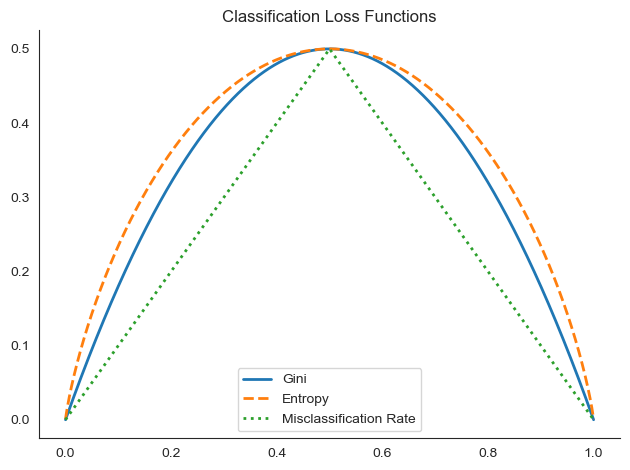

In [4]:
def entropy(f):
    return (-f*np.log2(f) - (1-f)*np.log2(1-f))/2

def gini(f):
    return 2*f*(1-f)

def misclassification_rate(f):
    return np.where(f<=.5, f, 1-f)

x = np.linspace(0, 1, 10000)
(pd.DataFrame({'Gini': gini(x), 
              'Entropy': entropy(x),
             'Misclassification Rate': misclassification_rate(x)}, index=x)
 .plot(title='Classification Loss Functions', lw=2, style=['-', '--', ':']))
sns.despine()
plt.tight_layout();


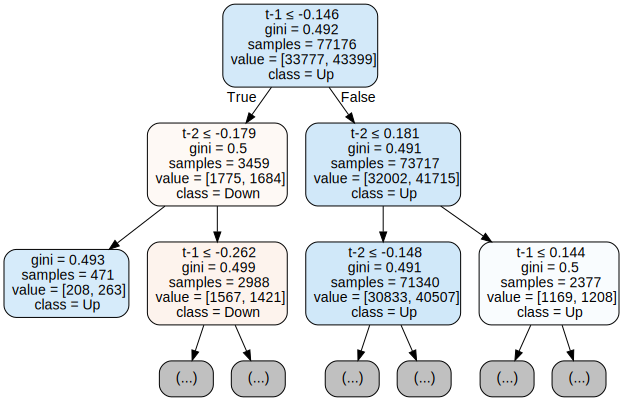

In [6]:
# Compare computation time

# Gini is often preferred over entropy because it computes faster:

misclassification_rate(x)

gini(x)

entropy(x)

# Configure Tree

clf_tree_t2 = DecisionTreeClassifier(criterion='gini',
                                     splitter='best',
                                     max_depth=5,
                                     min_samples_split=1000,
                                     min_samples_leaf=1,
                                     min_weight_fraction_leaf=0.0,
                                     max_features=None,
                                     random_state=42,
                                     max_leaf_nodes=None,
                                     min_impurity_decrease=0.0,
                                     class_weight=None)

# Train Tree

y_binary = (y2>0).astype(int)

clf_tree_t2.fit(X=X2, y=y_binary)

clf_tree_t2.fit(X=X2, y=y_binary)

DecisionTreeClassifier(max_depth=5, min_samples_split=1000, random_state=42)

# Visualize Tree

out_file = results_path / 'clf_tree_t2.dot'
dot_data = export_graphviz(clf_tree_t2,
                           out_file=out_file.as_posix(),
                           feature_names=X2.columns,
                           class_names=['Down', 'Up'],
                           max_depth=2,
                           filled=True,
                           rounded=True,
                           special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

